In [2]:
import pandas as pd
import numpy as np
from numpy import percentile
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from tabulate import tabulate

# Removes the limit for the number of displayed columns
pd.set_option("display.max_columns", None)
# Sets the limit for the number of displayed rows
pd.set_option("display.max_rows", 200)

In [3]:
# Correct the file path 
veh_data = r'C:\Users\johnC\Downloads\archive\car details v4.csv'

# Load the dataset
car_data_v4 = pd.read_csv(veh_data)

# Display the first few rows as a table that can be copied easily
print(tabulate(car_data_v4.head(), headers='keys', tablefmt='grid'))

# Display general information about the dataset
car_data_v4_info = car_data_v4.info()


+----+---------------+---------------------------------+---------+--------+-------------+-------------+----------------+------------+---------+---------+---------------+----------+--------------------+------------------------+--------------+----------+---------+----------+--------------------+----------------------+
|    | Make          | Model                           |   Price |   Year |   Kilometer | Fuel Type   | Transmission   | Location   | Color   | Owner   | Seller Type   | Engine   | Max Power          | Max Torque             | Drivetrain   |   Length |   Width |   Height |   Seating Capacity |   Fuel Tank Capacity |
+====+===============+=================================+=========+========+=============+=============+================+============+=========+=========+===============+==========+====================+========================+==============+==========+=========+==========+====================+======================+
|  0 | Honda         | Amaze 1.2 VX i-VTEC    

In [4]:
import re

# Function to correct the 'Max Power' format
def correct_max_power_format(power):
    if isinstance(power, str):
        if 'bhp' not in power:
            try:
                power_value, rpm_value = re.split(r'@\s*', power, maxsplit=1)
                power = f"{power_value.strip()} bhp @ {rpm_value.strip()}"
            except ValueError:
                pass
        if 'rpm' not in power:
            power = f"{power} rpm"
        return power
    elif isinstance(power, float):
        return f"{power} bhp"
    else:
        return power

# Apply the correction to the 'Max Power' column
car_data_v4['Max Power'] = car_data_v4['Max Power'].apply(correct_max_power_format)

# Display a few corrected entries to confirm the changes
car_data_v4['Max Power'].sample(10)

882      82 bhp @ 6000 rpm
2024    138 bhp @ 4000 rpm
924     117 bhp @ 6600 rpm
545     184 bhp @ 4000 rpm
1387    184 bhp @ 4000 rpm
1574               nan bhp
1688    174 bhp @ 4200 rpm
1632     94 bhp @ 6000 rpm
1031    168 bhp @ 3750 rpm
407      83 bhp @ 6000 rpm
Name: Max Power, dtype: object

In [5]:
# Calculate the median fuel tank capacity for each seating capacity
median_fuel_capacity_by_seating = car_data_v4.groupby('Seating Capacity')['Fuel Tank Capacity'].median()

# Get the overall median fuel tank capacity
overall_median_fuel_capacity = car_data_v4['Fuel Tank Capacity'].median()

# Fill missing values in 'Fuel Tank Capacity' based on the 'Seating Capacity' median or overall median
car_data_v4['Fuel Tank Capacity'] = car_data_v4.apply(
    lambda row: median_fuel_capacity_by_seating.get(row['Seating Capacity'], overall_median_fuel_capacity) if pd.isna(row['Fuel Tank Capacity']) else row['Fuel Tank Capacity'],
    axis=1
)

# Check if any missing values remain in the 'Fuel Tank Capacity'
remaining_missing_values = car_data_v4['Fuel Tank Capacity'].isnull().sum()
remaining_missing_values

0

In [6]:
car_data_v4['Seating Capacity'].isnull().sum()

64

In [7]:
# Calculate the most common 'Seating Capacity' for each 'Model'
mode_seating_by_model = car_data_v4.groupby('Model')['Seating Capacity'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)

# Fill missing values in 'Seating Capacity' based on the 'Model'
car_data_v4['Seating Capacity'] = car_data_v4.apply(
    lambda row: mode_seating_by_model[row['Model']] if pd.isna(row['Seating Capacity']) else row['Seating Capacity'],
    axis=1
)

# Check if any missing values remain in the 'Seating Capacity'
remaining_missing_seating = car_data_v4['Seating Capacity'].isnull().sum()
remaining_missing_seating


52

In [8]:
# Fill missing values for numerical features with the median
numerical_features = ['Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
car_data_v4[numerical_features] = car_data_v4[numerical_features].fillna(car_data_v4[numerical_features].median())

# Fill missing values for categorical features with the mode (most frequent value)
categorical_features = ['Engine', 'Max Power', 'Max Torque', 'Drivetrain']
for feature in categorical_features:
    mode_value = car_data_v4[feature].mode()[0]
    car_data_v4[feature] = car_data_v4[feature].fillna(mode_value)

# Check if any missing values remain
remaining_missing_values = car_data_v4.isnull().sum()

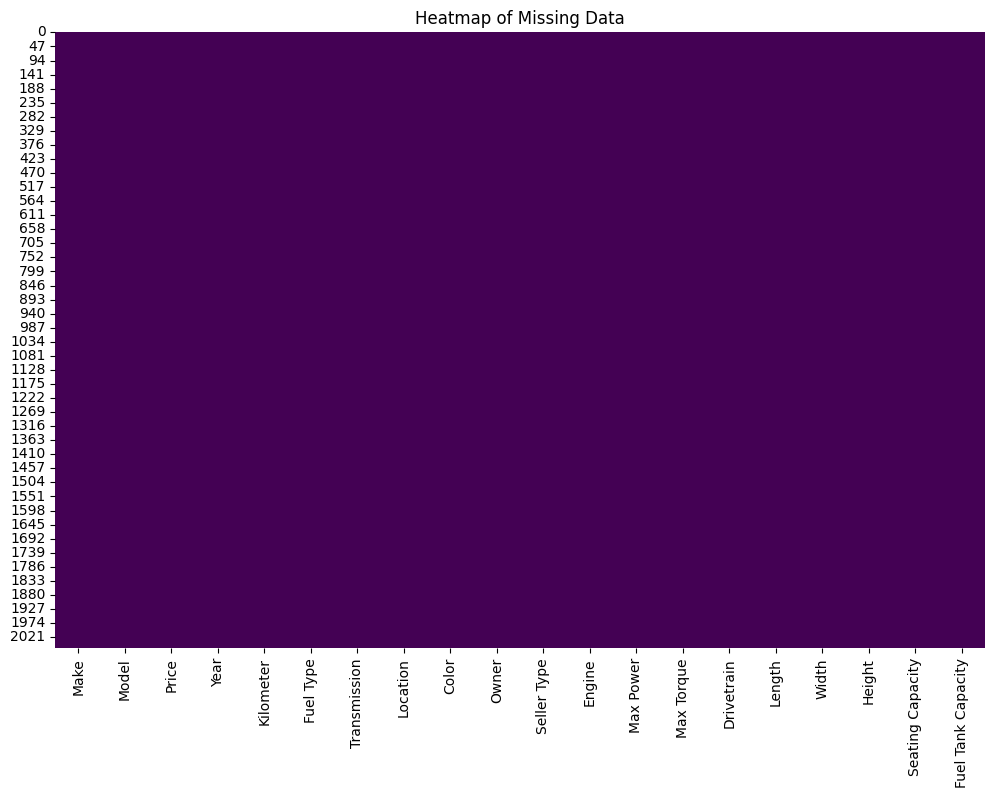

In [9]:

plt.figure(figsize=(12, 8))
sns.heatmap(car_data_v4.isnull(), cbar=False, cmap='viridis')
plt.title('Heatmap of Missing Data')
plt.show()


C:\Users\johnC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\johnC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


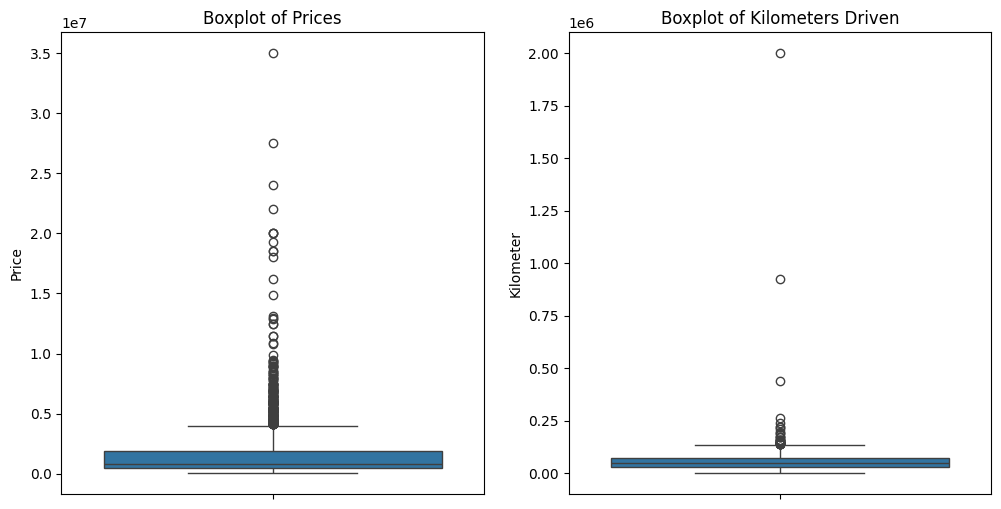

Potential outliers in Price: 215
Potential outliers in Kilometers Driven: 36


In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting boxplots to visualize outliers
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.boxplot(y=car_data_v4['Price'])
plt.title('Boxplot of Prices')

plt.subplot(1, 2, 2)
sns.boxplot(y=car_data_v4['Kilometer'])
plt.title('Boxplot of Kilometers Driven')

plt.show()

# Calculating IQR for potential removal criteria
Q1_price = car_data_v4['Price'].quantile(0.25)
Q3_price = car_data_v4['Price'].quantile(0.75)
IQR_price = Q3_price - Q1_price
lower_bound_price = Q1_price - 1.5 * IQR_price
upper_bound_price = Q3_price + 1.5 * IQR_price

Q1_km = car_data_v4['Kilometer'].quantile(0.25)
Q3_km = car_data_v4['Kilometer'].quantile(0.75)
IQR_km = Q3_km - Q1_km
lower_bound_km = Q1_km - 1.5 * IQR_km
upper_bound_km = Q3_km + 1.5 * IQR_km

# Displaying potential outliers based on IQR criterion
outliers_price = car_data_v4[(car_data_v4['Price'] < lower_bound_price) | (car_data_v4['Price'] > upper_bound_price)]
outliers_km = car_data_v4[(car_data_v4['Kilometer'] < lower_bound_km) | (car_data_v4['Kilometer'] > upper_bound_km)]

print(f"Potential outliers in Price: {len(outliers_price)}")
print(f"Potential outliers in Kilometers Driven: {len(outliers_km)}")


In [11]:
car_data_v4.describe()

,Price,Year,Kilometer,Length,Width,Height,Seating Capacity,Fuel Tank Capacity
count,2.059000e+03,2059.000000,2.059000e+03,2059.000000,2059.000000,2059.000000,2059.000000,2059.000000
mean,1.702992e+06,2016.425449,5.422471e+04,4283.631374,1768.054395,1590.282661,5.296746,51.920981
std,2.419881e+06,3.363564,5.736172e+04,435.799127,133.146412,134.186875,0.811029,14.760064
min,4.900000e+04,1988.000000,0.000000e+00,3099.000000,1475.000000,1165.000000,2.000000,15.000000
25%,4.849990e+05,2014.000000,2.900000e+04,3986.000000,1695.000000,1485.000000,5.000000,42.000000
50%,8.250000e+05,2017.000000,5.000000e+04,4370.000000,1770.000000,1545.000000,5.000000,50.000000
75%,1.925000e+06,2019.000000,7.200000e+04,4620.000000,1831.000000,1672.000000,5.000000,60.000000
max,3.500000e+07,2022.000000,2.000000e+06,5569.000000,2220.000000,1995.000000,8.000000,105.000000


In [12]:
# Check for missing values
missing_values = car_data_v4.isnull().sum()
print(missing_values)

Make                  0
Model                 0
Price                 0
Year                  0
Kilometer             0
Fuel Type             0
Transmission          0
Location              0
Color                 0
Owner                 0
Seller Type           0
Engine                0
Max Power             0
Max Torque            0
Drivetrain            0
Length                0
Width                 0
Height                0
Seating Capacity      0
Fuel Tank Capacity    0
dtype: int64


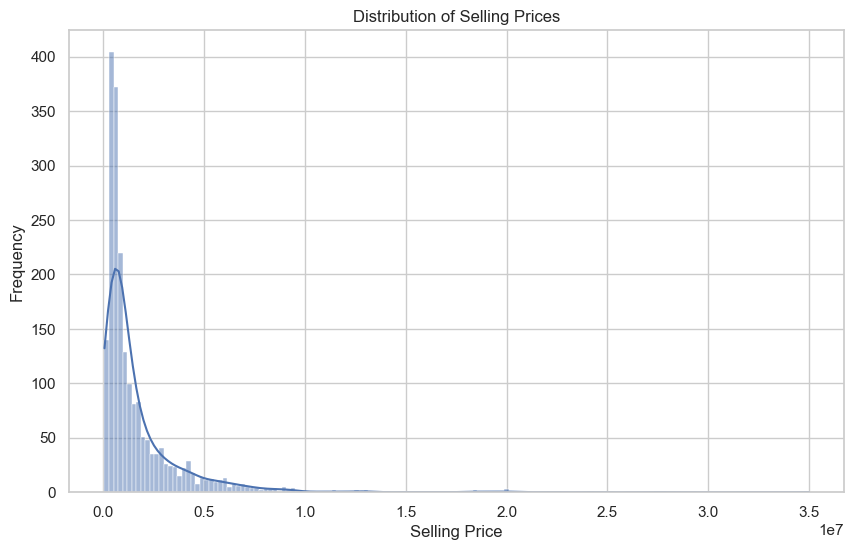

C:\Users\johnC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


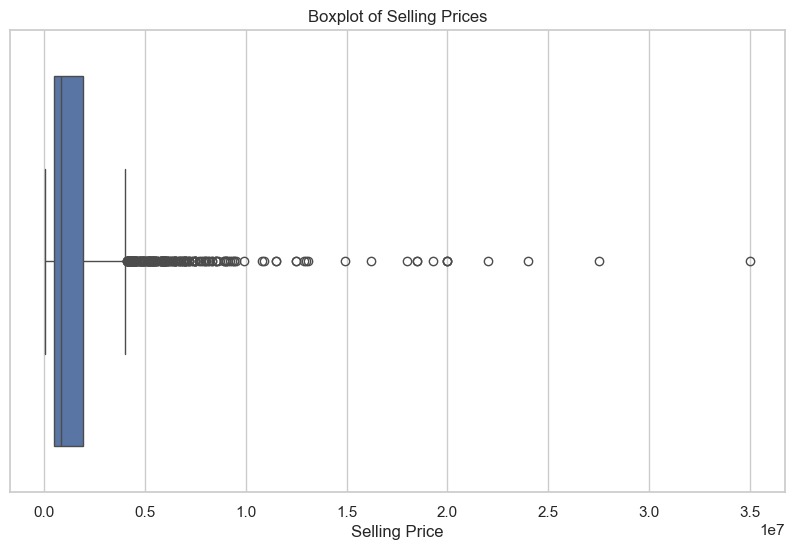

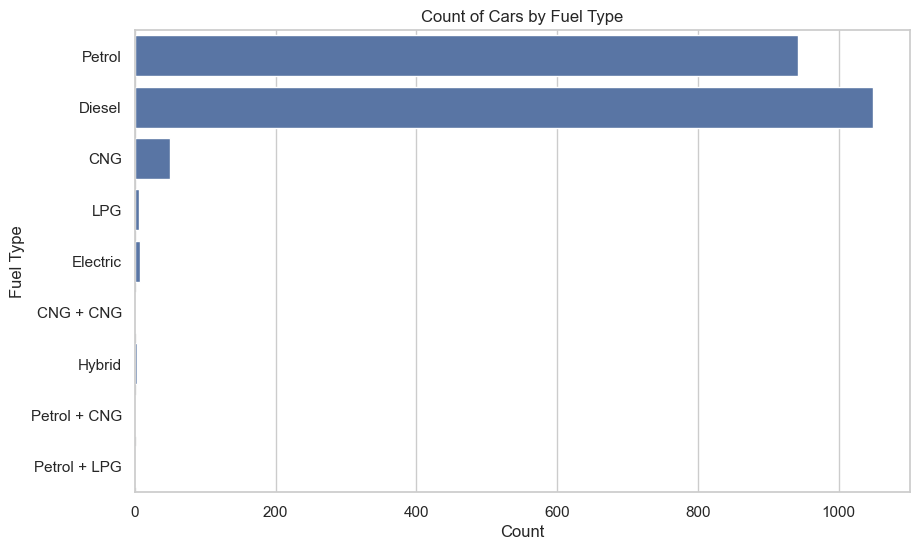

In [13]:
# Data Visualization

# Set up the visualization layout
sns.set(style="whitegrid")

# Histogram of a numerical variable
plt.figure(figsize=(10, 6))
sns.histplot(car_data_v4['Price'], kde=True)
plt.title('Distribution of Selling Prices')
plt.xlabel('Selling Price')
plt.ylabel('Frequency')
plt.show()

# Boxplot for numerical variable to check for outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=car_data_v4['Price'])
plt.title('Boxplot of Selling Prices')
plt.xlabel('Selling Price')
plt.show()

# Count plot for a categorical variable
plt.figure(figsize=(10, 6))
sns.countplot(y=car_data_v4['Fuel Type'])
plt.title('Count of Cars by Fuel Type')
plt.xlabel('Count')
plt.ylabel('Fuel Type')
plt.show()

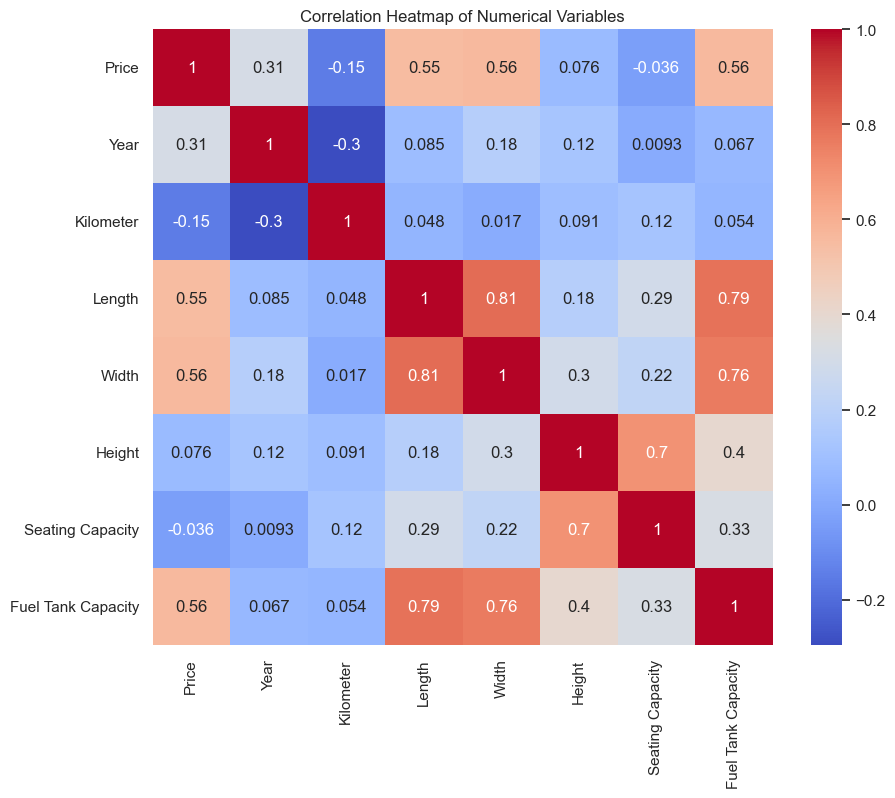

In [14]:
numerical_vars = car_data_v4.select_dtypes(include=[np.number])

# Calculating the correlation matrix
correlation_matrix = numerical_vars.corr()

# Creating the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Variables')
plt.show()


In [15]:
from scipy.stats import chi2_contingency

# Function to calculate Cramér's V for all pairs of categorical columns
def calculate_cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k - 1)*(r - 1))/(n - 1))    
    r_corr = r - ((r - 1)**2)/(n - 1)
    k_corr = k - ((k - 1)**2)/(n - 1)
    return np.sqrt(phi2_corr / min((k_corr - 1), (r_corr - 1)))

# Calculate Cramér's V for each pair of categorical variables
categorical_vars = car_data_v4.select_dtypes(include=['category', 'object'])
categorical_columns = categorical_vars.columns
cramers_v_matrix = pd.DataFrame(index=categorical_columns, columns=categorical_columns)

# Populate the matrix with Cramér's V values
for col1 in categorical_columns:
    for col2 in categorical_columns:
        cramers_v_matrix.loc[col1, col2] = calculate_cramers_v(categorical_vars[col1], categorical_vars[col2])

cramers_v_matrix = cramers_v_matrix.astype(float)

# Display the Cramér's V matrix
cramers_v_matrix.round(2)


,Make,Model,Fuel Type,Transmission,Location,Color,Owner,Seller Type,Engine,Max Power,Max Torque,Drivetrain
Make,1.00,0.71,0.26,0.68,0.04,0.14,0.09,0.14,0.72,0.79,0.79,0.61
Model,0.71,1.00,0.55,0.70,0.17,0.25,0.35,0.17,0.71,0.75,0.74,0.70
Fuel Type,0.26,0.55,1.00,0.21,0.04,0.07,0.12,0.00,0.42,0.53,0.55,0.28
Transmission,0.68,0.70,0.21,1.00,0.37,0.26,0.08,0.11,0.69,0.70,0.69,0.43
Location,0.04,0.17,0.04,0.37,1.00,0.13,0.11,0.25,0.06,0.03,0.08,0.11
Color,0.14,0.25,0.07,0.26,0.13,1.00,0.00,0.00,0.15,0.27,0.17,0.19
Owner,0.09,0.35,0.12,0.08,0.11,0.00,1.00,0.00,0.26,0.37,0.42,0.07
Seller Type,0.14,0.17,0.00,0.11,0.25,0.00,0.00,1.00,0.03,0.00,0.16,0.00
Engine,0.72,0.71,0.42,0.69,0.06,0.15,0.26,0.03,1.00,0.88,0.89,0.71
Max Power,0.79,0.75,0.53,0.70,0.03,0.27,0.37,0.00,0.88,1.00,0.87,0.81


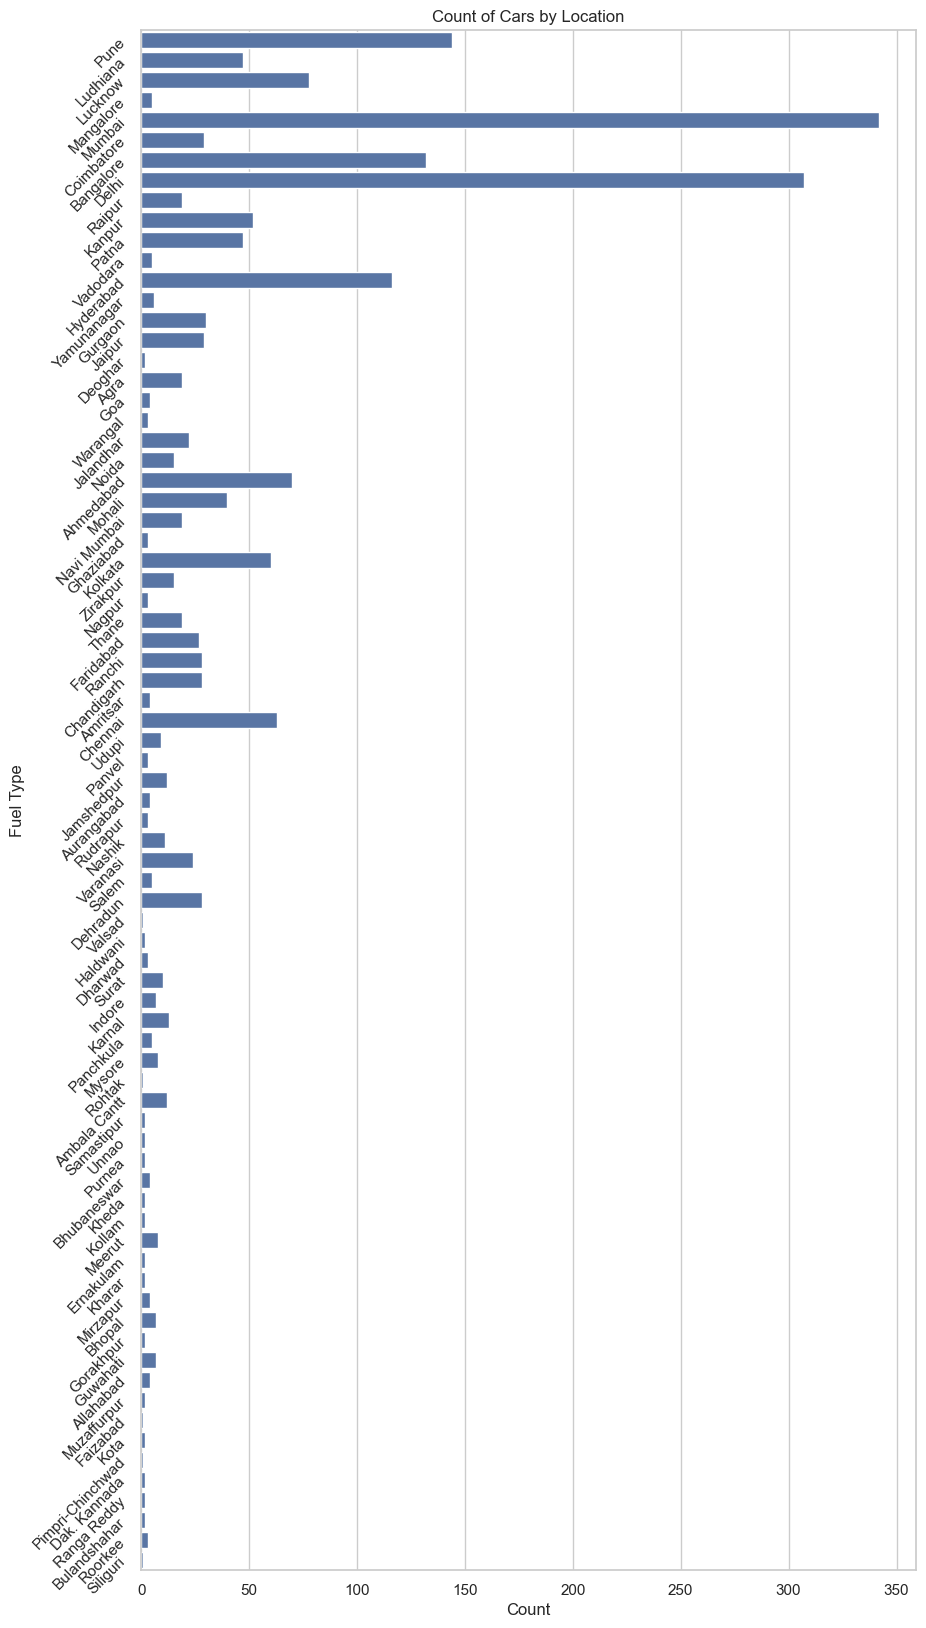

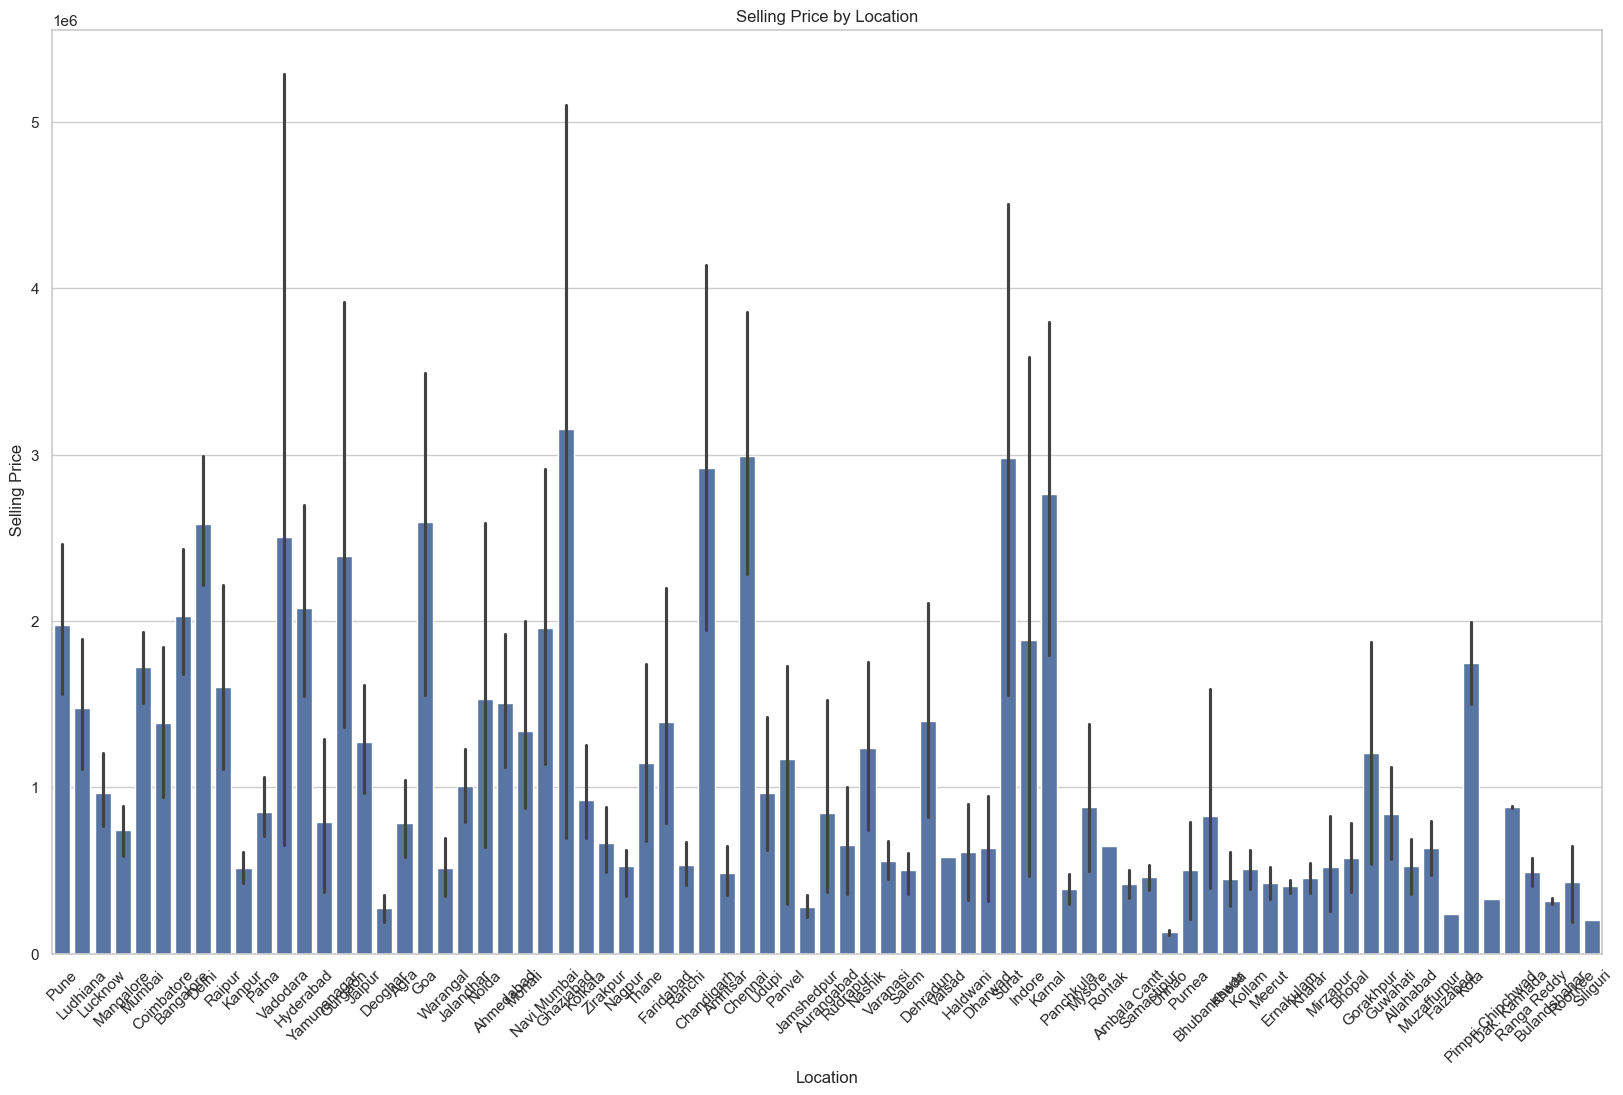

In [16]:
plt.figure(figsize=(10, 20))
sns.countplot(y=car_data_v4['Location'])
plt.title('Count of Cars by Location')
plt.xlabel('Count')
plt.ylabel('Fuel Type')
plt.yticks(rotation=45)
plt.show()

plt.figure(figsize=(20, 12))
sns.barplot(x='Location', y='Price', data=car_data_v4)
plt.title('Selling Price by Location')
plt.xlabel('Location')
plt.ylabel(' Selling Price')
plt.xticks(rotation=45) 
plt.show()

In [17]:
import pandas as pd

# Calculate the necessary statistics
grouped = car_data_v4.groupby('Year')['Price'].agg(['mean', 'min', 'max', 'count'])

# Renaming columns for clarity
grouped.columns = ['Average Price', 'Minimum Price', 'Maximum Price', 'Number of Cars']

# Resetting index to make 'Year' a column
grouped.reset_index(inplace=True)

# Display the table
print(grouped)


    Year  Average Price  Minimum Price  Maximum Price  Number of Cars
0   1988   1.300000e+06        1300000        1300000               1
1   1996   1.300000e+05         130000         130000               1
2   2000   1.200000e+06        1200000        1200000               1
3   2002   1.000000e+05         100000         100000               1
4   2004   7.100100e+04          71001          71001               1
5   2006   2.200000e+05         190000         250000               2
6   2007   7.388332e+05         178000        2100000               6
7   2008   2.140000e+05         135000         495000              13
8   2009   3.130303e+05         120000        1500000              33
9   2010   5.080370e+05          49000        2400000              27
10  2011   9.797088e+05         150000       20000000              79
11  2012   9.871630e+05         114999       20000000              92
12  2013   6.770156e+05         190000        4390000             128
13  2014   1.036312e

In [26]:
grouped.to_csv('car_price_summary_by_year.csv', index=False)

In [25]:
from tabulate import tabulate

# Convert the DataFrame to a plain text table
table_format = tabulate(grouped, headers='keys', tablefmt='pretty')
print(table_format)

+----+--------+--------------------+---------------+---------------+----------------+
|    |  Year  |   Average Price    | Minimum Price | Maximum Price | Number of Cars |
+----+--------+--------------------+---------------+---------------+----------------+
| 0  | 1988.0 |     1300000.0      |   1300000.0   |   1300000.0   |      1.0       |
| 1  | 1996.0 |      130000.0      |   130000.0    |   130000.0    |      1.0       |
| 2  | 2000.0 |     1200000.0      |   1200000.0   |   1200000.0   |      1.0       |
| 3  | 2002.0 |      100000.0      |   100000.0    |   100000.0    |      1.0       |
| 4  | 2004.0 |      71001.0       |    71001.0    |    71001.0    |      1.0       |
| 5  | 2006.0 |      220000.0      |   190000.0    |   250000.0    |      2.0       |
| 6  | 2007.0 | 738833.1666666666  |   178000.0    |   2100000.0   |      6.0       |
| 7  | 2008.0 |      214000.0      |   135000.0    |   495000.0    |      13.0      |
| 8  | 2009.0 | 313030.30303030304 |   120000.0    |  

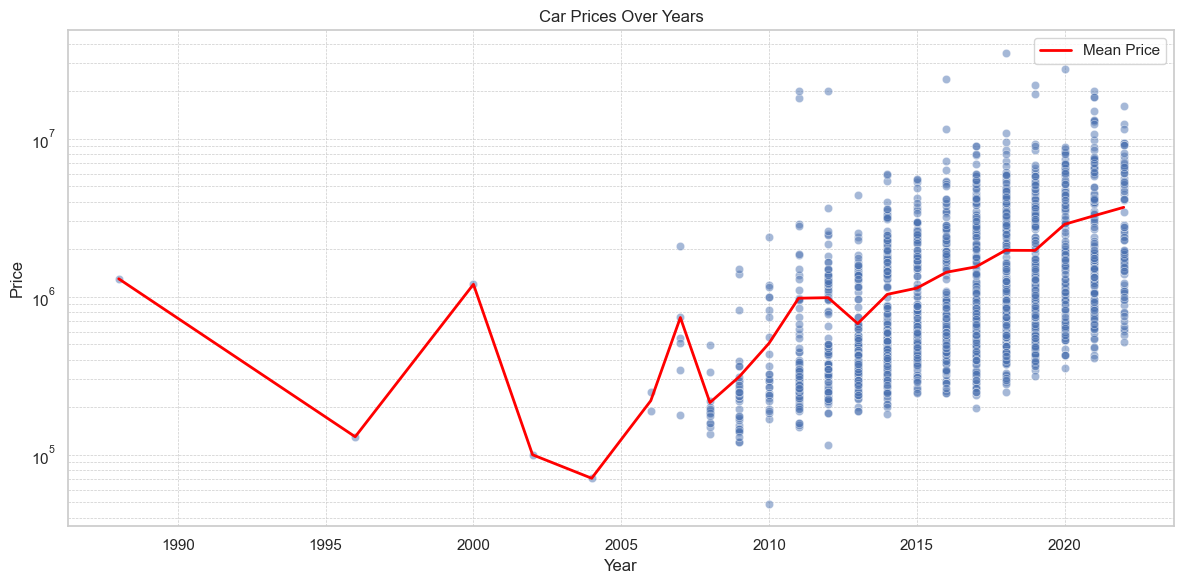

In [18]:
# Since there are no missing values in 'Year' and 'Price', we can proceed with the plot.
plt.figure(figsize=(12, 6))

# Scatter plot with alpha to reduce overplotting
plt.scatter(car_data_v4['Year'], car_data_v4['Price'], alpha=0.5, edgecolor='w', linewidth=0.5)

# Mean price trend line
mean_prices = car_data_v4.groupby('Year')['Price'].mean()
plt.plot(mean_prices.index, mean_prices.values, color='red', label='Mean Price', linewidth=2)

# Plot settings
plt.title('Car Prices Over Years')
plt.xlabel('Year')
plt.ylabel('Price')
plt.yscale('log')  # Log scale for the price axis
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping

# Show the improved plot
plt.show()


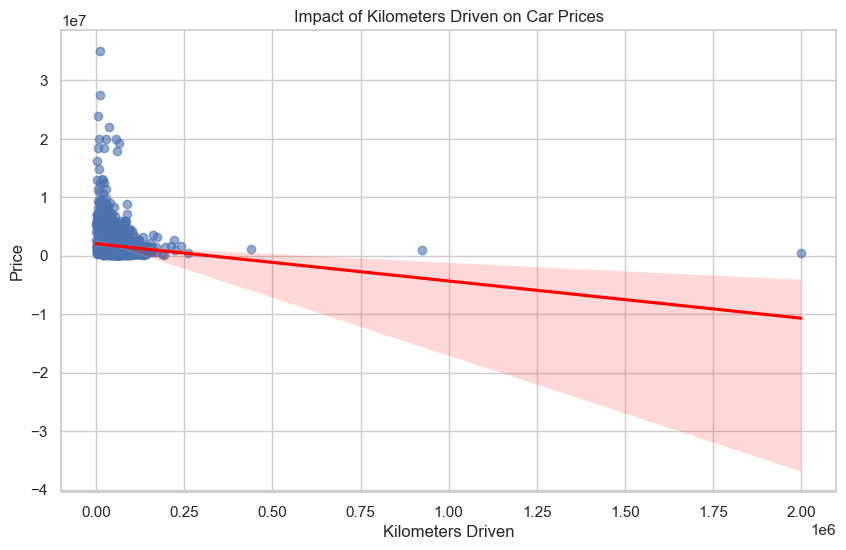

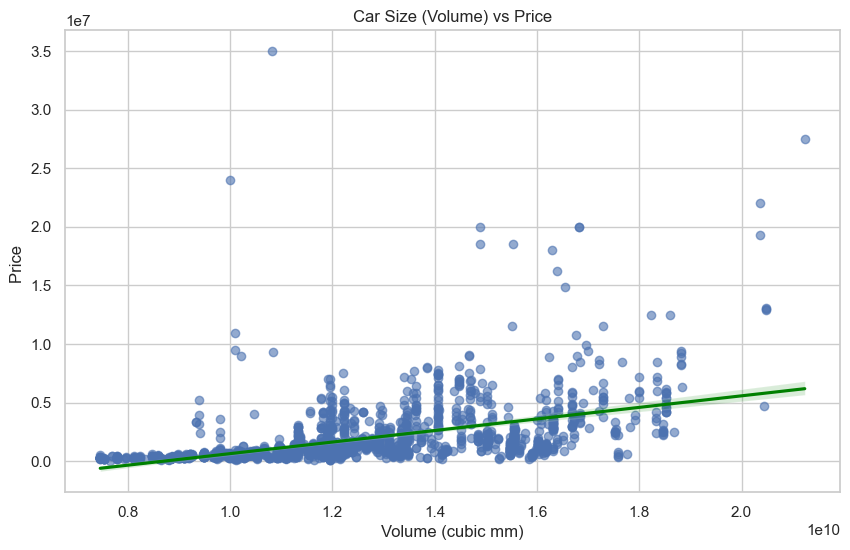

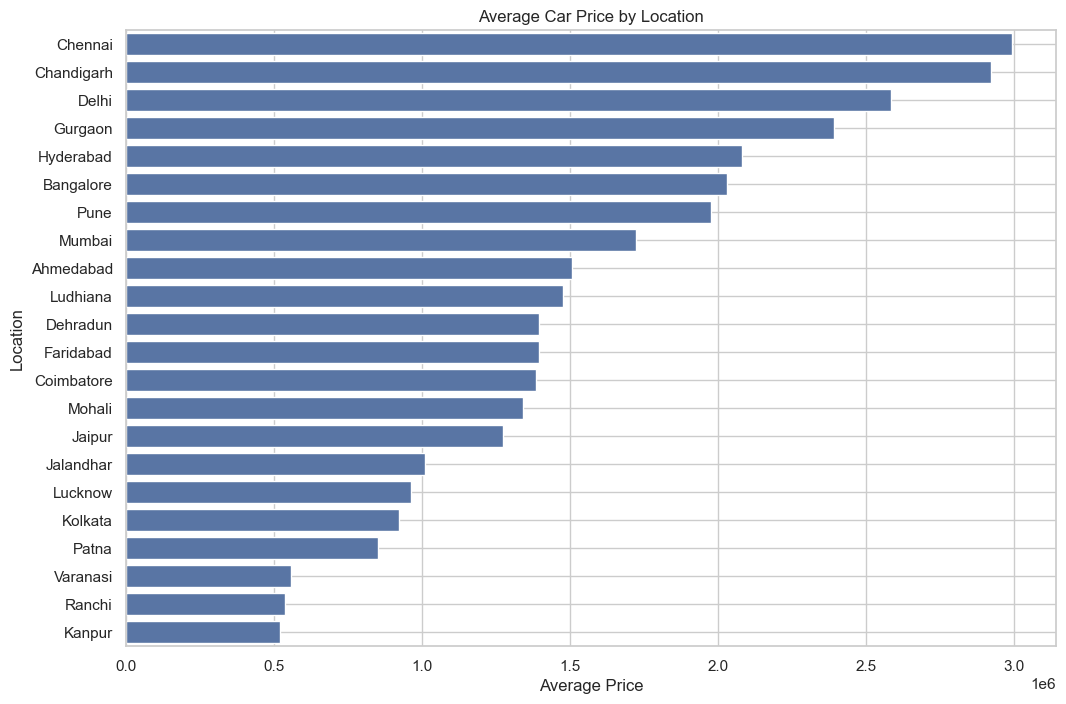

In [19]:
# Conduct further analyses in Python based on the specified criteria

# Influence of Kilometers Driven
plt.figure(figsize=(10, 6))
sns.regplot(x='Kilometer', y='Price', data=car_data_v4, scatter_kws={'alpha':0.6}, line_kws={'color':'red'})
plt.title('Impact of Kilometers Driven on Car Prices')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.grid(True)
plt.show()

# Effect of Car Size (Dimensions)
# Calculate volume as an approximate product of length, width, and height
car_data_v4['Volume'] = car_data_v4['Length'] * car_data_v4['Width'] * car_data_v4['Height']

plt.figure(figsize=(10, 6))
sns.regplot(x='Volume', y='Price', data=car_data_v4, scatter_kws={'alpha':0.6}, line_kws={'color':'green'})
plt.title('Car Size (Volume) vs Price')
plt.xlabel('Volume (cubic mm)')
plt.ylabel('Price ')
plt.grid(True)
plt.show()

# Regional Trends
average_price_by_location = car_data_v4.groupby('Location').agg(
    Average_Price=('Price', 'mean'),
    Car_Count=('Price', 'size')
).reset_index()

average_price_by_location = average_price_by_location[average_price_by_location['Car_Count'] > 20]

plt.figure(figsize=(12, 8))
sns.barplot(x='Average_Price', y='Location', data=average_price_by_location.sort_values('Average_Price', ascending=False))
plt.title('Average Car Price by Location')
plt.xlabel('Average Price')
plt.ylabel('Location')
plt.grid(True)
plt.show()


C:\Users\johnC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
C:\Users\johnC\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\seaborn\categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


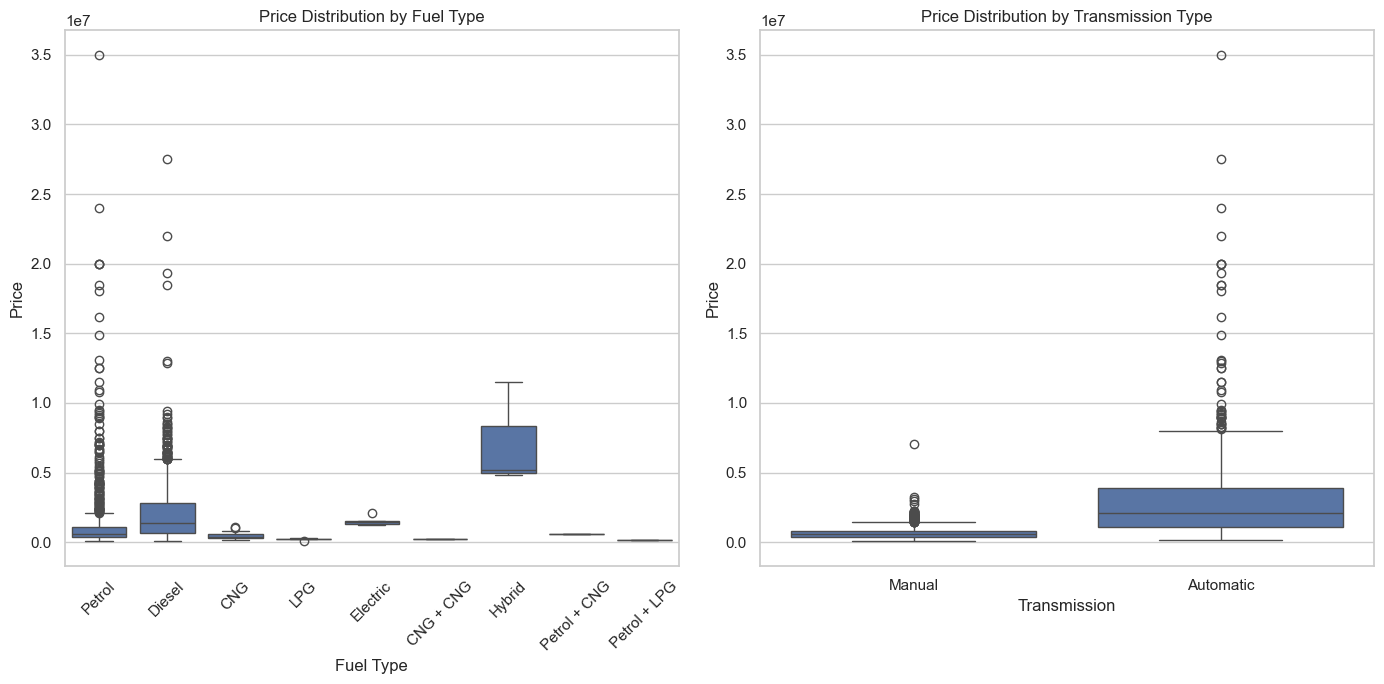

In [20]:
# Creating box plots for categorical variables 'Fuel Type' and 'Transmission'

plt.figure(figsize=(14, 7))
plt.subplot(1, 2, 1)
sns.boxplot(x='Fuel Type', y='Price', data=car_data_v4)
plt.title('Price Distribution by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Price')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.boxplot(x='Transmission', y='Price', data=car_data_v4)
plt.title('Price Distribution by Transmission Type')
plt.xlabel('Transmission')
plt.ylabel('Price')

plt.tight_layout()
plt.show()


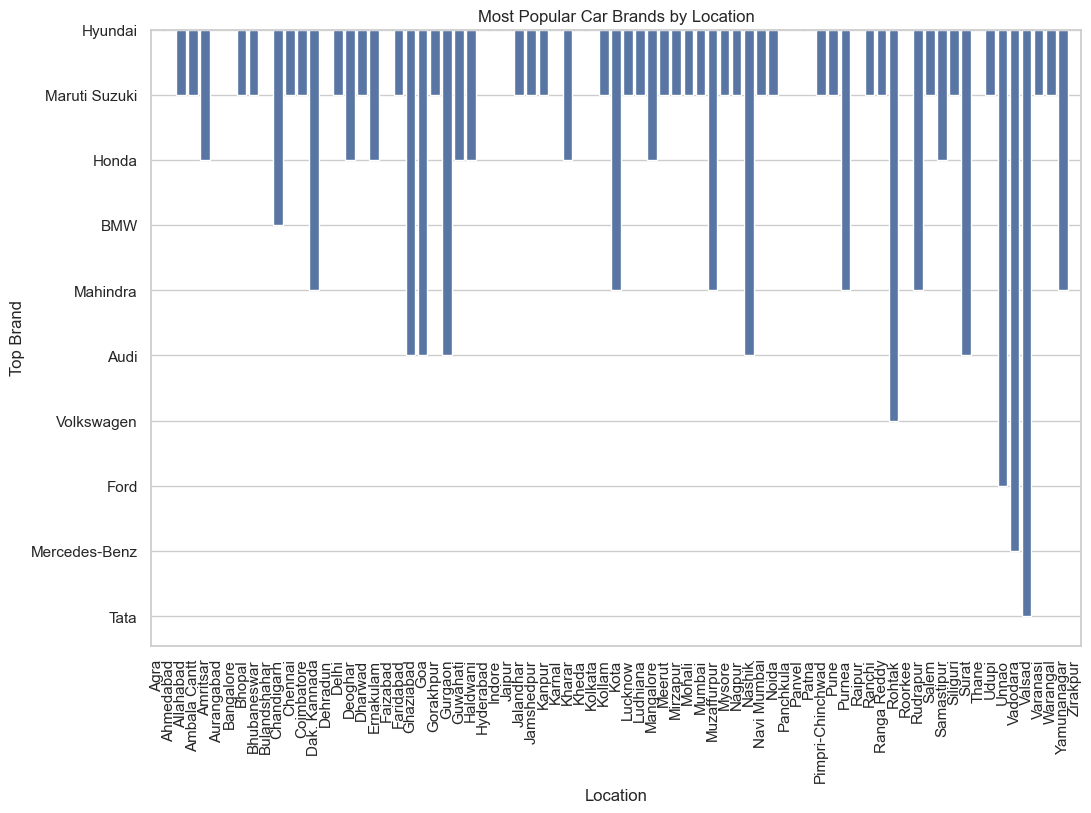

<Figure size 1200x800 with 0 Axes>

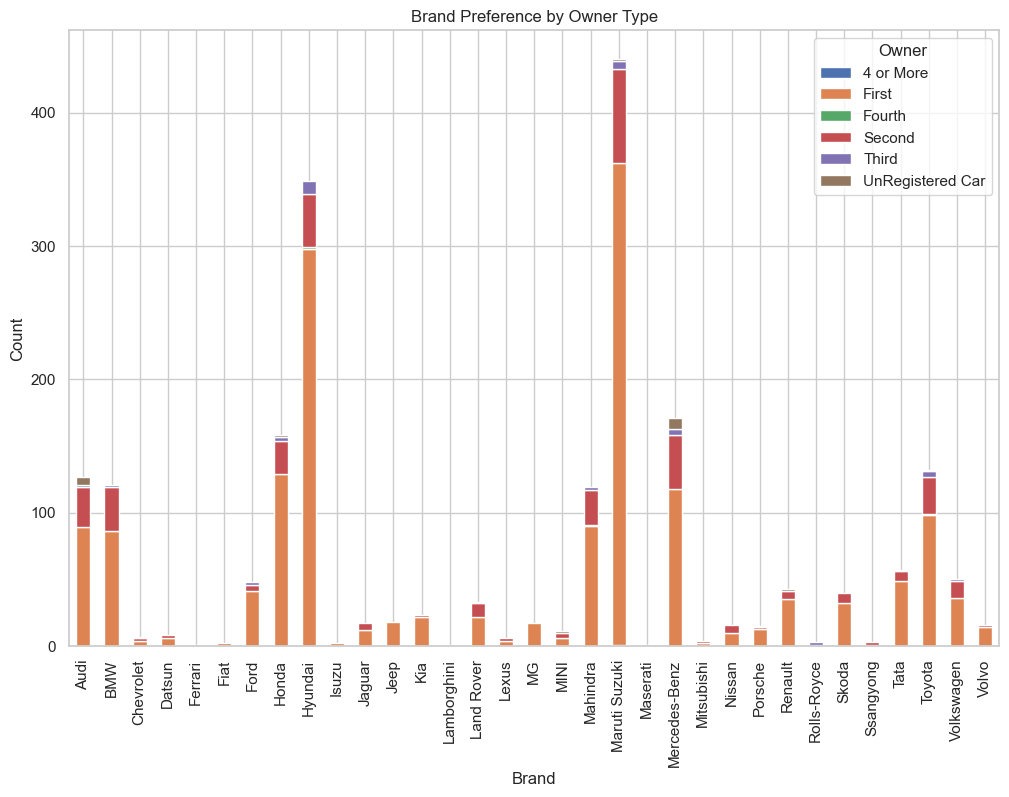

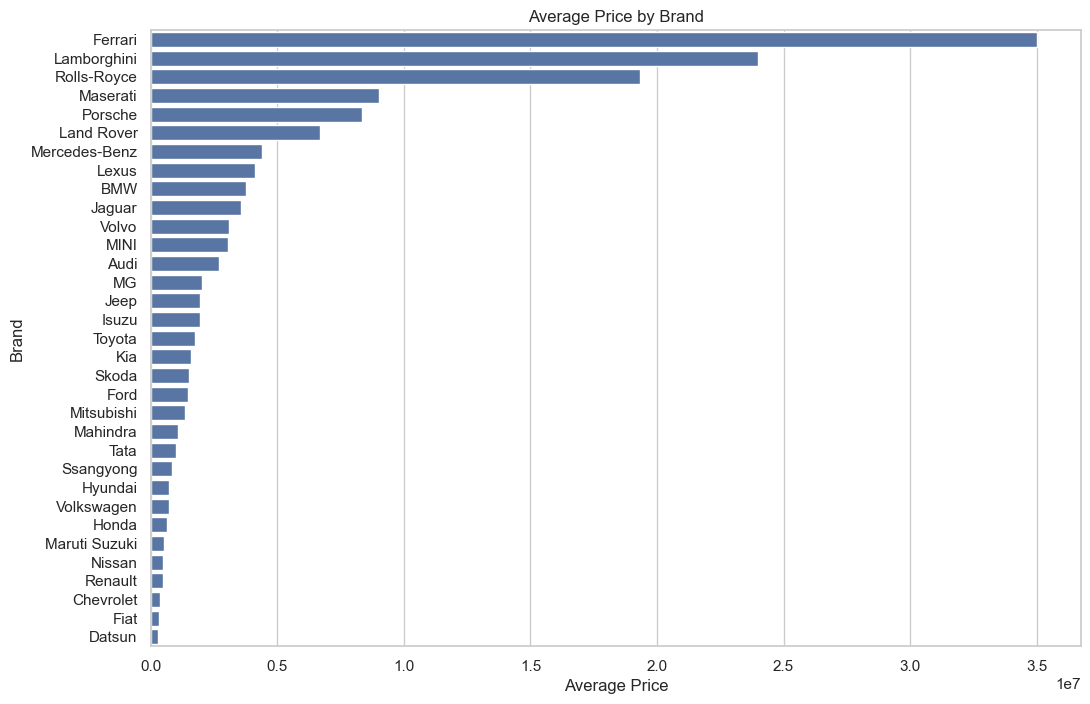

In [21]:


# Brand Preference by Location
top_brands_by_location = car_data_v4.groupby(['Location', 'Make']).size().unstack().fillna(0)
top_brands_by_location = top_brands_by_location.idxmax(axis=1)  # Finding the most popular brand in each location

# Brand Preference by Owner Type
brand_by_owner_type = pd.crosstab(car_data_v4['Make'], car_data_v4['Owner'])

# Brand and Price Correlation
average_price_by_brand = car_data_v4.groupby('Make')['Price'].mean().sort_values(ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x=top_brands_by_location.index, y=top_brands_by_location.values)
plt.xticks(rotation=90)
plt.title('Most Popular Car Brands by Location')
plt.ylabel('Top Brand')
plt.xlabel('Location')
plt.show()

plt.figure(figsize=(12, 8))
brand_by_owner_type.plot(kind='bar', stacked=True, figsize=(12, 8))
plt.title('Brand Preference by Owner Type')
plt.ylabel('Count')
plt.xlabel('Brand')
plt.show()

plt.figure(figsize=(12, 8))
sns.barplot(x=average_price_by_brand.values, y=average_price_by_brand.index)
plt.title('Average Price by Brand')
plt.xlabel('Average Price')
plt.ylabel('Brand')
plt.show()


In [22]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Selecting only the numerical columns for modeling
numerical_features = ['Year', 'Kilometer', 'Length', 'Width', 'Height', 'Seating Capacity', 'Fuel Tank Capacity']
X = car_data_v4[numerical_features]
y = car_data_v4['Price']

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Calculate RMSE and R² score
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

rmse, r2

(1119318.484020026, 0.8206665813452386)

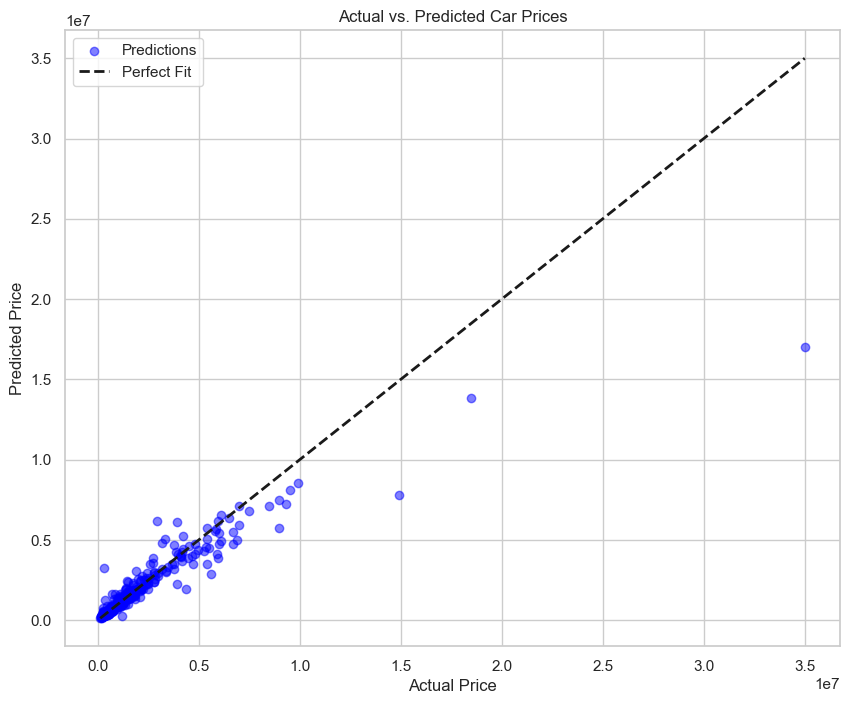

In [23]:
import matplotlib.pyplot as plt

# Creating the scatter plot
plt.figure(figsize=(10, 8))
plt.scatter(y_test, y_pred, alpha=0.5, color='blue', label='Predictions')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2, label='Perfect Fit')

# Adding titles and labels
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs. Predicted Car Prices')
plt.legend()

# Display the plot
plt.grid(True)
plt.show()


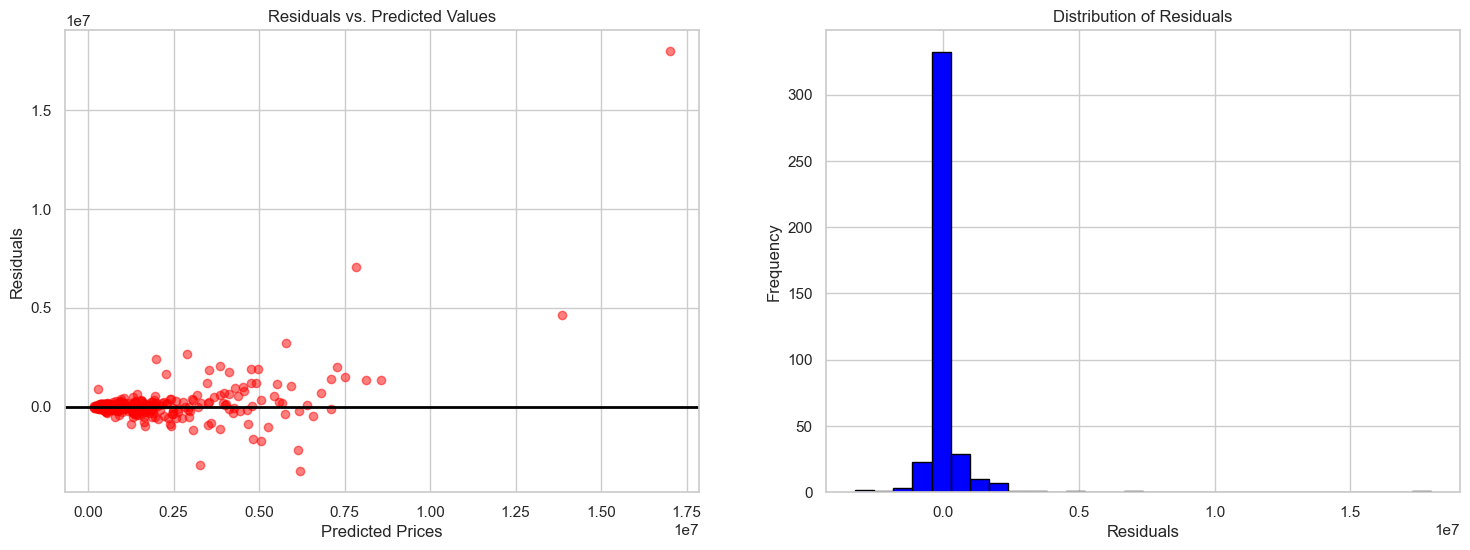

In [24]:
import matplotlib.pyplot as plt

# Calculate residuals
residuals = y_test - y_pred

# Create plots for residual analysis
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))

# Residual vs. Predicted Plot
ax1.scatter(y_pred, residuals, alpha=0.5, color='red')
ax1.axhline(0, color='black', lw=2)
ax1.set_title('Residuals vs. Predicted Values')
ax1.set_xlabel('Predicted Prices')
ax1.set_ylabel('Residuals')
ax1.grid(True)

# Histogram of the Residuals
ax2.hist(residuals, bins=30, color='blue', edgecolor='black')
ax2.set_title('Distribution of Residuals')
ax2.set_xlabel('Residuals')
ax2.set_ylabel('Frequency')
ax2.grid(True)

# Show plots
plt.show()
